#### Half Causal Estimator
https://it.tradingview.com/script/QETnobDk-Half-Causal-Estimator/

In [2]:
# Definizione delle Enumerazioni e Tipi

from enum import Enum

# Enumerazioni per sorgente dati e tipo di kernel
class Source(Enum):
    VOL = "Volume"
    TR = "True Range"
    CHANGE = "Change"

class KernelType(Enum):
    GAUSSIAN = "Gaussian"
    EPANECHNIKOV = "Epanechnikov"
    TRIANGULAR = "Triangular"

# Classi per tipi personalizzati
class Key:
    def __init__(self, m=0, h=0):
        self.m = m
        self.h = h

class Vec:
    def __init__(self, values=None):
        self.values = values if values is not None else []

class Data:
    def __init__(self, data, valid):
        self.data = data
        self.valid = valid

class Settings:
    def __init__(self, data_period=0, filter_length=10, window_size=20, kernel_width=10, kernel_type=KernelType.EPANECHNIKOV):
        self.data_period = data_period
        self.filter_length = filter_length
        self.window_size = window_size
        self.kernel_width = kernel_width
        self.kernel_type = kernel_type

In [3]:
# Funzioni di Supporto per i Dati

import numpy as np
import pandas as pd

def init_data(timeframe_multiplier):
    """Inizializza la struttura dati per memorizzare i valori per ogni slot temporale."""
    size = 1440 // timeframe_multiplier  # 1440 minuti in un giorno
    data = [Vec() for _ in range(size)]
    valid = [False] * size
    return Data(data, valid)

def key_to_hash(key, timeframe_multiplier):
    """Converte una chiave (ora/minuto) in un indice hash."""
    return int((key.h * 60 + key.m) / timeframe_multiplier)

def advance_key(key, forward, timeframe_multiplier):
    """Avanza la chiave temporale di un numero di slot."""
    advanced_minute = key.m + (forward * timeframe_multiplier)
    new_minute = advanced_minute % 60
    new_hour = (key.h + (advanced_minute // 60)) % 24
    return Key(new_minute, new_hour)

def maintain(lst, length):
    """Mantiene la lunghezza della lista rimuovendo elementi vecchi."""
    if length > 0 and len(lst) >= length:
        lst.pop()

def add_pop(lst, value, length):
    """Aggiunge un elemento in testa e mantiene la lunghezza."""
    maintain(lst, length)
    lst.insert(0, value)

def add_element(data, source, length, timeframe_multiplier):
    """Aggiunge un elemento ai dati in base all'ora corrente."""
    current_time = pd.Timestamp.now()
    idx = key_to_hash(Key(current_time.minute, current_time.hour), timeframe_multiplier)
    if not np.isnan(source):
        if data.valid[idx]:
            add_pop(data.data[idx].values, source, length)
        else:
            data.data[idx] = Vec([source])
            data.valid[idx] = True

def get_average(data, key, timeframe_multiplier):
    """Calcola la media dei valori per una chiave specifica."""
    idx = key_to_hash(key, timeframe_multiplier)
    if data.valid[idx] and data.data[idx].values:
        return np.mean(data.data[idx].values)
    return np.nan

In [4]:
# Funzioni di Filtering

def gaussian_kernel(source, bandwidth):
    """Kernel Gaussiano."""
    ratio = source / bandwidth
    return np.exp(-np.power(ratio, 2) / 2) / np.sqrt(2 * np.pi)

def epanechnikov_kernel(source, bandwidth):
    """Kernel Epanechnikov."""
    ratio = source / bandwidth
    return (3 / 4.) * (1 - np.power(ratio, 2)) if abs(ratio) <= 1 else 0.0

def triangular_kernel(source, bandwidth):
    """Kernel Triangolare."""
    ratio = source / bandwidth
    return 1 - abs(ratio) if abs(ratio) <= 1 else 0.0

def select_kernel(source, config):
    """Seleziona il kernel in base alla configurazione."""
    if config.kernel_type == KernelType.GAUSSIAN:
        return gaussian_kernel(source, config.kernel_width)
    elif config.kernel_type == KernelType.EPANECHNIKOV:
        return epanechnikov_kernel(source, config.kernel_width)
    elif config.kernel_type == KernelType.TRIANGULAR:
        return triangular_kernel(source, config.kernel_width)

def kernel_coef(config):
    """Calcola i coefficienti normalizzati del kernel."""
    coef = np.zeros(config.window_size)
    normalization = 0
    for i in range(config.window_size):
        j = i - (config.window_size - 1) / 2
        weight = select_kernel(j, config)
        normalization += weight
        coef[i] = weight
    return coef / normalization if normalization > 0 else coef

In [5]:
# Funzioni dell'Estimator

def init_make_window(ahead, data, size, key_now, timeframe_multiplier):
    """Inizializza la finestra con dati futuri basati su pattern storici."""
    return_key = Key(0, 0)
    ahead.clear()
    idx = 1
    while len(ahead) < size:
        key = advance_key(key_now, idx, timeframe_multiplier)
        if data.valid[key_to_hash(key, timeframe_multiplier)]:
            return_key = key
            value = get_average(data, key, timeframe_multiplier)
            ahead.insert(0, value)
        idx += 1
    return return_key

def maintain_window(ahead, window_key, data, timeframe_multiplier):
    """Mantiene la finestra aggiornandola con nuovi dati."""
    key_now = window_key
    return_key = window_key
    size = len(ahead)
    ahead.pop()
    idx = 1
    while len(ahead) < size:
        key = advance_key(key_now, idx, timeframe_multiplier)
        if data.valid[key_to_hash(key, timeframe_multiplier)]:
            return_key = key
            value = get_average(data, key, timeframe_multiplier)
            ahead.insert(0, value)
        idx += 1
    return return_key

def make_window(source, data, ready, config, timeframe_multiplier):
    """Crea la finestra composita di dati passati e futuri."""
    window_key = Key(0, 0)
    buffer = []
    ahead = []
    current_time = pd.Timestamp.now()
    key_now = Key(current_time.minute, current_time.hour)
    add_pop(buffer, source, config.filter_length)
    if ready:
        # Simuliamo 'isfirstbar' con una condizione iniziale
        if len(data.data[0].values) <= config.window_size:
            window_key = init_make_window(ahead, data, config.filter_length - 1, key_now, timeframe_multiplier)
        else:
            window_key = maintain_window(ahead, window_key, data, timeframe_multiplier)
    window = ahead + buffer
    return window

def make_smooth(window, ready, config):
    """Applica lo smoothing alla finestra usando il kernel."""
    if ready and len(window) == config.window_size:
        kernel = kernel_coef(config)
        return np.dot(window, kernel)
    return np.nan

In [6]:
# Funzione Principale

def half_causal_estimator(df, data_source=Source.VOL, data_period=5, filter_length=20, kernel_width=20, kernel_type=KernelType.EPANECHNIKOV, timeframe_multiplier=1):
    """
    Calcola l'Half Causal Estimator su un dataframe OHLCV.
    
    Parametri:
    - df: DataFrame con colonne 'open', 'high', 'low', 'close', 'volume'
    - data_source: Source (VOL, TR, CHANGE)
    - data_period: Numero di giorni di dati da memorizzare (0 per tutti)
    - filter_length: Lunghezza del filtro storico
    - kernel_width: Larghezza del kernel
    - kernel_type: Tipo di kernel
    - timeframe_multiplier: Multiplo del timeframe in minuti (es. 1 per 1 minuto)
    
    Ritorna:
    - pd.Series con i valori stimati
    """
    config = Settings(data_period, filter_length, filter_length * 2 - 1, kernel_width, kernel_type)
    data = init_data(timeframe_multiplier)
    estimates = []
    
    for i in range(len(df)):
        # Selezione della sorgente dati
        if data_source == Source.VOL:
            source = df.iloc[i]['volume']
        elif data_source == Source.TR:
            source = (df.iloc[i]['high'] - df.iloc[i]['low']) / df.iloc[i]['low'] * 100
        else:  # Source.CHANGE
            source = abs(df.iloc[i]['close'] - df.iloc[i-1]['close']) / min(df.iloc[i]['close'], df.iloc[i-1]['close']) * 100 if i > 0 else np.nan
        
        # Determina se siamo pronti (dopo abbastanza dati)
        ready = i > config.window_size
        
        # Costruisci la finestra e calcola lo smooth
        window = make_window(source, data, ready, config, timeframe_multiplier)
        smooth = make_smooth(window, ready, config)
        
        # Aggiungi il dato corrente alla struttura
        add_element(data, source, config.data_period, timeframe_multiplier)
        estimates.append(smooth)
    
    return pd.Series(estimates, index=df.index)

In [7]:
# Esempio di utilizzo
import pandas as pd

df = pd.read_csv('Bitcoin (USDT) 2024 timeframe 1m.csv')

# Supponiamo che 'df' sia il tuo DataFrame OHLCV
enriched_df = half_causal_estimator(
    df,
    data_source=Source.VOL,
    data_period=5,
    filter_length=20,
    kernel_width=20,
    kernel_type=KernelType.EPANECHNIKOV,
    timeframe_multiplier=1
)
df['Half_Causal_Estimator'] = enriched_df
df

,timestamp,open,high,low,close,volume,Half_Causal_Estimator
0,2024-01-01 00:00:00,42284.00,42300.00,42260.01,42300.00,15.059749,NaN
1,2024-01-01 00:01:00,42300.00,42321.99,42299.99,42320.28,4.240722,NaN
2,2024-01-01 00:02:00,42320.28,42335.79,42317.30,42322.57,5.671511,NaN
3,2024-01-01 00:03:00,42322.57,42370.00,42322.57,42366.50,6.801620,NaN
4,2024-01-01 00:04:00,42366.50,42399.68,42366.50,42399.68,6.264730,NaN
...,...,...,...,...,...,...,...
527036,2024-12-31 23:56:00,93677.94,93687.52,93631.52,93631.52,2.998654,NaN
527037,2024-12-31 23:57:00,93631.52,93646.28,93608.35,93608.35,3.858137,NaN
527038,2024-12-31 23:58:00,93608.35,93621.75,93596.78,93596.78,3.780835,NaN
527039,2024-12-31 23:59:00,93596.78,93623.60,93571.00,93571.01,7.256212,NaN


### Hull Moving Average e Rate of Change

In [2]:
import numpy as np
import pandas as pd

def weighted_moving_average(series, period):
    weights = np.arange(1, period + 1)
    wma = series.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma

def hull_moving_average(series, n=20):
    # Step 1: WMA con periodo n/2 (arrotondato)
    wma_half = weighted_moving_average(series, int(np.round(n / 2)))
    
    # Step 2: WMA con periodo n
    wma_full = weighted_moving_average(series, n)
    
    # Step 3: Calcolo della differenza
    diff = 2 * wma_half - wma_full
    
    # Step 4: WMA sulla diff con periodo sqrt(n) (arrotondato)
    hma = weighted_moving_average(diff, int(np.round(np.sqrt(n))))
    
    return hma

# Esempio con dati casuali
np.random.seed(42)
data = pd.read_csv('Bitcoin (USDT) 2024 timeframe 1m.csv')['close'].iloc[:100]

# Calcolo HMA con n=20
hma_result = hull_moving_average(data, n=5)

hma_result

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
          ...     
95    42606.513556
96    42671.455778
97    42732.592444
98    42780.780222
99    42767.423778
Name: close, Length: 100, dtype: float64

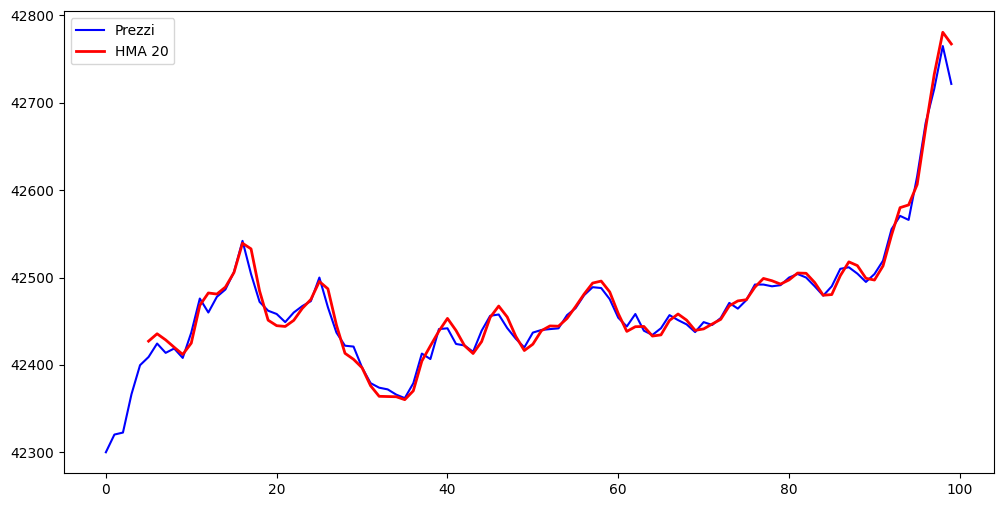

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data, label='Prezzi', color='blue')
plt.plot(hma_result, label='HMA 20', color='red', linewidth=2)
plt.legend()
plt.show()

Starting Grid Search on 1 combinations



C:\Users\Alessandro\AppData\Local\Temp\ipykernel_102752\2653834261.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[buy_condition.shift(1).fillna(False), 'Raw_Signal'] = 1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_102752\2653834261.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[sell_condition.shift(1).fillna(False), 'Raw_Signal'] = -1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_102752\2653834261.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a futur


Combo 1/1: HMA Period=5
Train Annualized: 1.00004338x (0.00433803%)
Test Annualized:  1.00015706x (0.01570552%)
🔥 New Best! Train: 1.00004338x | Params: {'hma_period': 5}

BEST COMBINATION:
Params: {'hma_period': 5}
Train Annualized: 1.00004338x
Test Annualized:  1.00015706x


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_102752\2653834261.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[buy_condition.shift(1).fillna(False), 'Raw_Signal'] = 1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_102752\2653834261.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[sell_condition.shift(1).fillna(False), 'Raw_Signal'] = -1


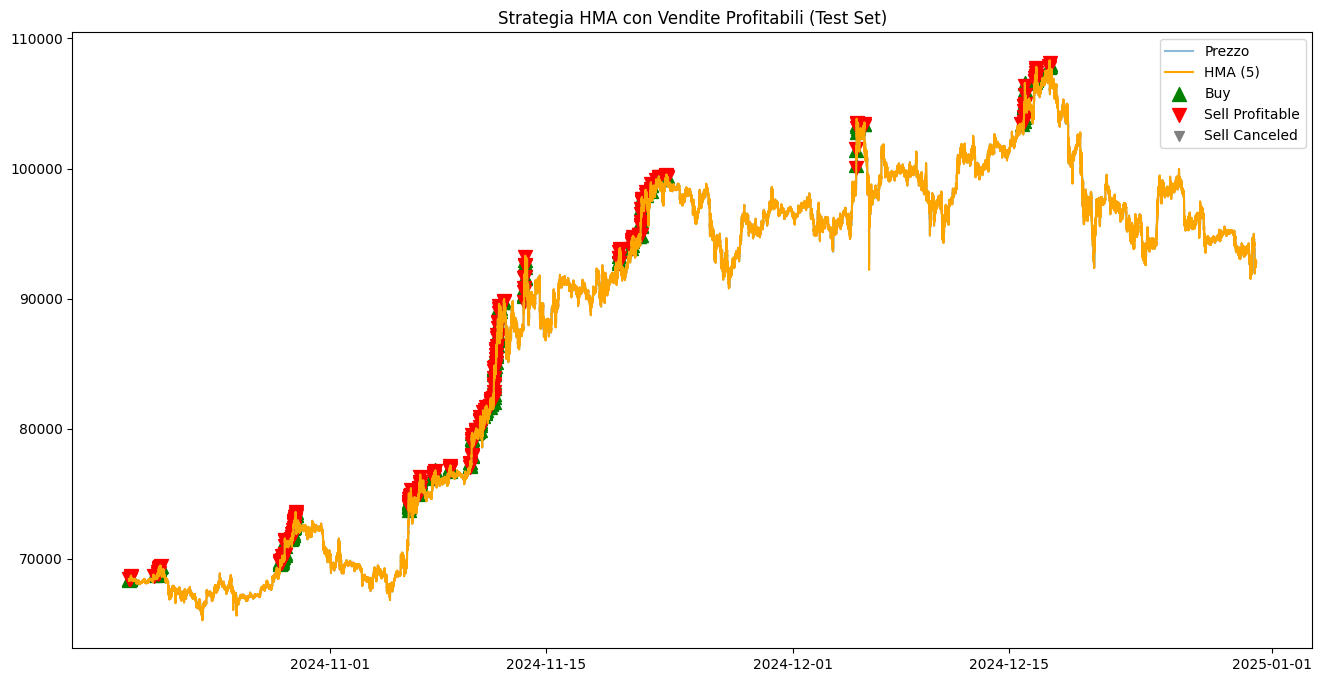

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

def hull_moving_average(series, n):
    def weighted_moving_average(series, period):
        weights = np.arange(1, period + 1)
        return series.rolling(period).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
    
    wma_half = weighted_moving_average(series, int(np.round(n/2)))
    wma_full = weighted_moving_average(series, n)
    diff = 2 * wma_half - wma_full
    hma = weighted_moving_average(diff, int(np.round(np.sqrt(n))))
    return hma

def backtest_strategy(data, hma_period):
    data = data.copy()
    data['HMA'] = hull_moving_average(data['close'], hma_period)
    
    # Calcolo punti di inversione
    data['HMA_prev'] = data['HMA'].shift(1)
    data['HMA_next'] = data['HMA'].shift(-1)
    
    # Condizioni base
    buy_condition = (data['HMA'] < data['HMA_prev']) & (data['HMA'] < data['HMA_next'])
    sell_condition = (data['HMA'] > data['HMA_prev']) & (data['HMA'] > data['HMA_next'])
    
    # Inizializzazione colonne segnale
    data['Raw_Signal'] = 0
    data.loc[buy_condition.shift(1).fillna(False), 'Raw_Signal'] = 1
    data.loc[sell_condition.shift(1).fillna(False), 'Raw_Signal'] = -1

    # Gestione logica di acquisto/vendita con prezzo di acquisto
    in_position = False
    buy_price = 0.0
    signals = []
    
    for idx, row in data.iterrows():
        if row['Raw_Signal'] == 1 and not in_position:
            signals.append(1)
            in_position = True
            buy_price = row['close']
        elif row['Raw_Signal'] == -1 and in_position:
            if row['close'] > buy_price:  # Condizione aggiuntiva per la vendita
                signals.append(-1)
                in_position = False
                buy_price = 0.0
            else:
                signals.append(0)
        else:
            signals.append(0)
    
    data['Signal'] = signals
    data['Position'] = data['Signal'].cumsum().apply(lambda x: 1 if x % 2 == 1 else 0)
    
    # Calcolo rendimenti
    data['Returns'] = data['close'].pct_change()
    data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']
    
    # Valore del portafoglio
    data['Portfolio'] = 1000 * (1 + data['Strategy_Returns'].fillna(0)).cumprod()
    
    return data.drop(['HMA_prev', 'HMA_next', 'Raw_Signal'], axis=1)

def grid_search(data, param_grid, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    best_params = None
    best_train = -np.inf
    best_test = -np.inf
    total_combo = len(list(product(*param_grid.values())))
    
    print(f"Starting Grid Search on {total_combo} combinations\n")
    
    for i, (n,) in enumerate(product(*param_grid.values())):
        params = {'hma_period': n}
        
        # Train
        train_res = backtest_strategy(train_data, n)
        train_final = train_res['Portfolio'].iloc[-1]
        train_ann = (train_final / 1000) ** (365 / len(train_res))
        
        # Test
        test_res = backtest_strategy(test_data, n)
        test_final = test_res['Portfolio'].iloc[-1]
        test_ann = (test_final / 1000) ** (365 / len(test_res))
        
        # Logging
        print(f"\nCombo {i+1}/{total_combo}: HMA Period={n}")
        print(f"Train Annualized: {train_ann:.8f}x ({train_ann*100-100:.8f}%)")
        print(f"Test Annualized:  {test_ann:.8f}x ({test_ann*100-100:.8f}%)")
        
        if train_ann > best_train:
            best_train = train_ann
            best_test = test_ann
            best_params = params
            print(f"🔥 New Best! Train: {train_ann:.8f}x | Params: {params}")
        else:
            print(f"Current Best: {best_train:.8f}x with {best_params}")

    print("\n" + "="*50)
    print(f"BEST COMBINATION:")
    print(f"Params: {best_params}")
    print(f"Train Annualized: {best_train:.8f}x")
    print(f"Test Annualized:  {best_test:.8f}x")
    print("="*50)
    
    return best_params, best_train, best_test

# Parametri e esecuzione
param_grid = {'hma_period': [5]}
data = pd.read_csv('Bitcoin (USDT) 2024 timeframe 1m.csv', parse_dates=['timestamp'], index_col='timestamp')
best_params, train_perf, test_perf = grid_search(data, param_grid)

# Plot risultati
test_data = data.iloc[int(len(data)*0.8):]
result = backtest_strategy(test_data.iloc[:], best_params['hma_period'])

result['Buy_Price'] = result['close'].where(result['Signal'] == 1).ffill()

plt.figure(figsize=(16,8))
plt.plot(result['close'], label='Prezzo', alpha=0.5)
plt.plot(result['HMA'], label=f'HMA ({best_params["hma_period"]})', color='orange')

# Evidenziazione trade profitabili
buy_signals = result[result['Signal'] == 1]
sell_signals = result[result['Signal'] == -1]
profitable_trades = sell_signals[sell_signals['close'] > sell_signals['Buy_Price']]

# Calcola le vendite annullate correttamente
canceled_trades = sell_signals.loc[sell_signals.index.difference(profitable_trades.index)]

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', c='green', s=100, label='Buy')
plt.scatter(profitable_trades.index, profitable_trades['close'], marker='v', c='red', s=100, label='Sell Profitable')
plt.scatter(canceled_trades.index, 
            canceled_trades['close'], 
            marker='v', c='grey', s=50, label='Sell Canceled')

plt.title('Strategia HMA con Vendite Profitabili (Test Set)')
plt.legend()
plt.show()